## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import modules for image processing

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [10]:
!python --version

python: can't open file 'opencv-python': [Errno 2] No such file or directory


In [278]:
import os; print(os.environ.get('QT_API'))

pyqt5


In [17]:
## Some my tests
img_test = cv2.imread('test_images/test1.jpg')
img_test_gray = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)

### Compute the camera calibration using chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:                       
        objpoints.append(objp)
        imgpoints.append(corners)

# perform camera calibration
[ret, mtx, dist, rvecs, tvecs] = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)

Now we have distortion coefficients: 

In [15]:
print(dist)

[[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]]


Camera matrix:

In [16]:
print(mtx)

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128937e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


and position of the camera in the world.

### Apply a distortion correction to raw images

In [3]:
# Make a list of test images
images = glob.glob('test_images/test*.jpg')
undistort_images = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # Undistort image
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undistort_images.append(img_undist)

### Show last test result (look at corners)

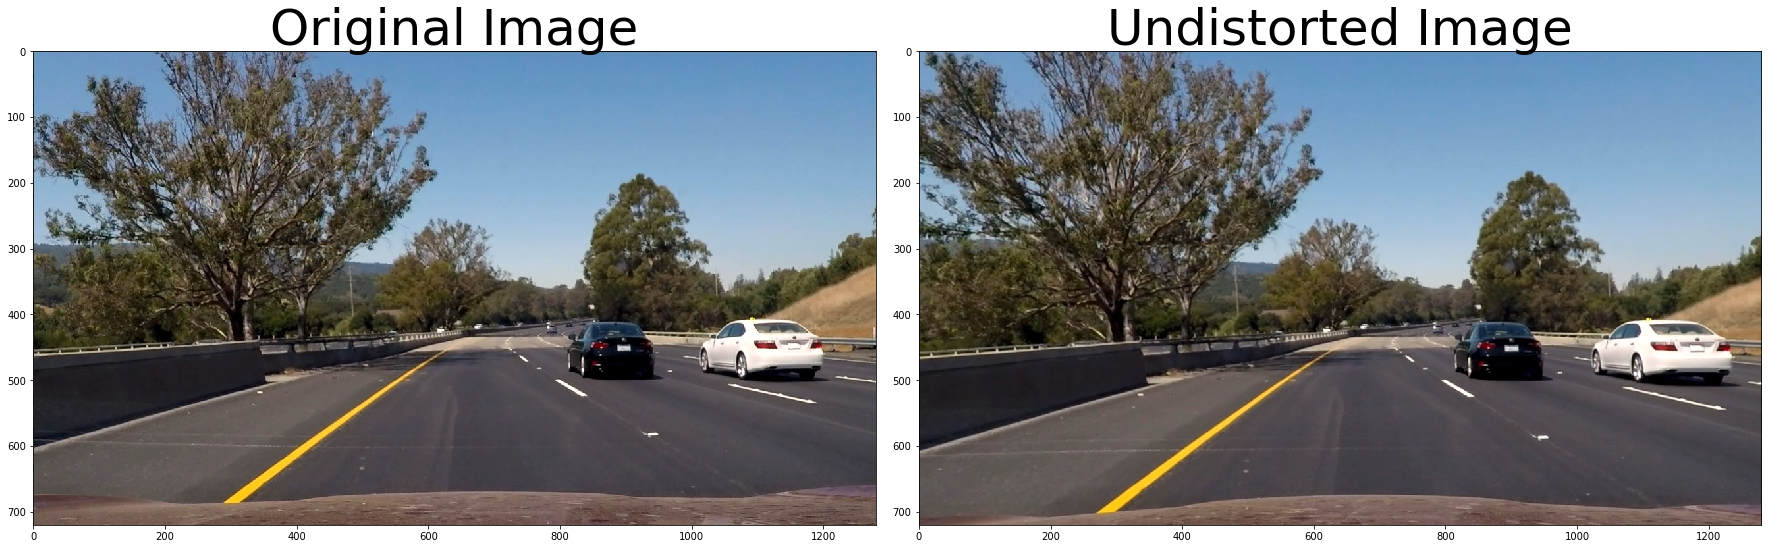

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transformation

#### Select points on reference image

In [2]:
def roi(img,vertices):
    # blank mask:
    mask = np.zeros_like(img)

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, 255)

    # returning the image only where mask pixels are nonzero
    masked = cv2.bitwise_and(img, mask)
    return masked

In [22]:
img_ref = cv2.imread('test_images/straight_lines1.jpg')

copy_img = img_ref
points = []
window_name = 'Choose source points'
cv2.namedWindow(window_name)
cv2.imshow(window_name, copy_img)
count = 0

"""
1. Choose upper left points
2. Choose upper right point
3. Choose bottom right point
4. Choose bottom left point 
"""

def mouseCB(event,x,y,flags,param):
    global count
    if event == cv2.EVENT_LBUTTONDBLCLK or event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(copy_img, (x, y), 3, (0, 0, 255), 3) #BGR
        if count == 0:
            cv2.line(copy_img, (x, y), (copy_img.shape[1], y), (0, 0, 255), 3)
        if count == 2:
            cv2.line(copy_img, (0, y), (x, y), (0, 0, 255), 3)
        count += 1
        points.append([x, y])
        cv2.imshow(window_name, copy_img)

cv2.setMouseCallback(window_name, mouseCB)
        
while True:
    ip = cv2.waitKey(0) & 0xFF
    if ip == ord('q'):
        break

cv2.destroyAllWindows()

In [23]:
# We suppose that lines are parallel
offset = 150 #distance from line

points_list = []
# upper left point
x = points[0][0] - offset
y = points[0][1]
print(x, y)
points_list.append([x, y])
# upper right point
x = points[1][0] + offset
y = points[0][1] # on the same level as upper left point
print(x, y)
points_list.append([x, y])
# bottom right point
x = points[2][0] + offset
y = points[2][1]
print(x, y)
points_list.append([x, y])
# bottom left point
x = points[3][0] - offset
y = points[2][1]
print(x, y)
points_list.append([x, y])

vertices = np.array([points_list], dtype=np.int32)

426 461
856 461
1185 669
128 669


In [24]:
print(points_list)
masked_img = roi(img_ref, vertices)
plt.imshow(masked_img)

[[426, 461], [856, 461], [1185, 669], [128, 669]]


NameError: name 'roi' is not defined

In [25]:

type(points)

list

In [26]:
[x, y, z] = img_ref.shape
offset_x = 10
offset_y = 400
dst = np.float32([[offset_x,offset_y],[x-offset_x,offset_y],[x-offset_x,y-offset_y],[offset_x,y-offset_y]])

In [16]:
type(dst)

numpy.ndarray

In [7]:
dst

array([[ 10., 400.],
       [710., 400.],
       [710., 880.],
       [ 10., 880.]], dtype=float32)

In [30]:
src = np.float32(points)
M = cv2.getPerspectiveTransform(src, dst)
type(M)

numpy.ndarray

In [14]:

img_size = (img_ref.shape[1], img_ref.shape[0])
warped = cv2.warpPerspective(img_ref, M, img_size, flags=cv2.INTER_LINEAR)

In [21]:
src=np.array([[415, 468],
   [871, 468],
   [1181, 667],
   [133, 667]], dtype=np.float32)
cv2.getPerspectiveTransform(src, dst)

array([[-7.47670574e-01, -1.09128773e+00,  8.16135407e+02],
       [-5.77579192e-16, -3.97097342e+00,  1.66359397e+03],
       [-9.09528028e-19, -3.17746576e-03,  1.00000000e+00]])

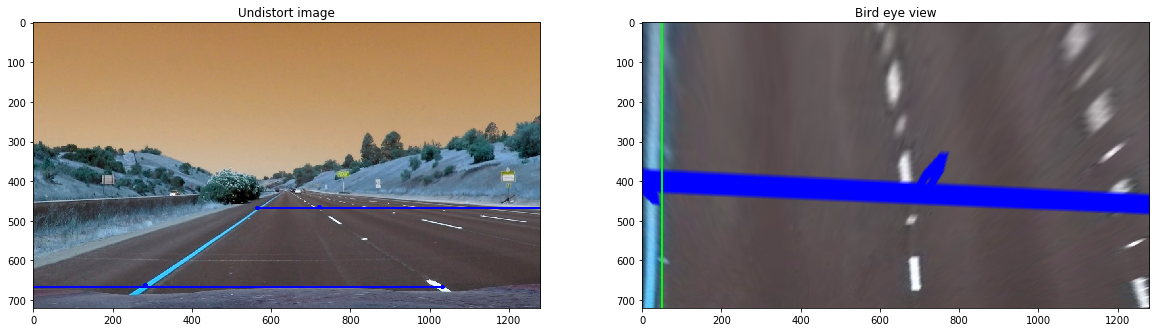

In [16]:
fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))
    
ax1.set_title('Undistort image')
ax1.imshow(img_ref)

lineThickness = 2
x = 50
cv2.line(warped, (x, 0), (x, y), (0,255,0), lineThickness)

ax2.set_title('Bird eye view')
ax2.imshow(warped)

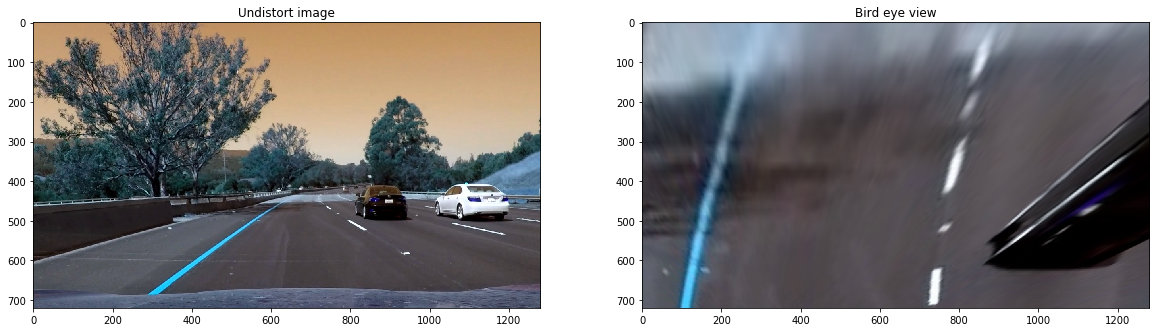

In [214]:
# Try the same M on curved right
img_ref_curve_right = cv2.imread('test_images/test6.jpg')
img_size = (img_ref_curve_right.shape[1], img_ref_curve_right.shape[0])
warped_curve_right = cv2.warpPerspective(img_ref_curve_right, M, img_size, flags=cv2.INTER_LINEAR)

# Display
fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))

ax1.set_title('Undistort image')
ax1.imshow(img_ref_curve_right)
    
ax2.set_title('Bird eye view')
ax2.imshow(warped_curve_right)

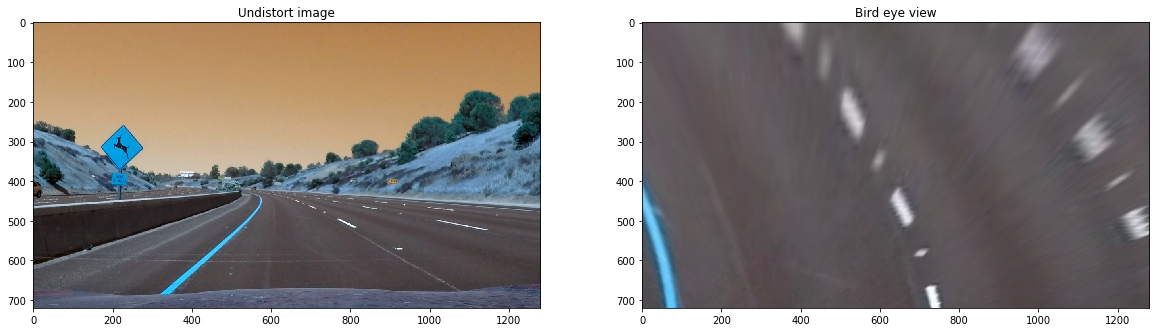

In [33]:
# Try the same M on curved left
img_ref_curve = cv2.imread('test_images/test2.jpg')
img_size = (img_ref_curve.shape[1], img_ref_curve.shape[0])
warped_curve = cv2.warpPerspective(img_ref_curve, M, img_size, flags=cv2.INTER_LINEAR)

fig, ((ax1, ax2)) = plt.subplots(ncols=2,
                                nrows=1,
                                figsize=(20,10))

ax1.set_title('Undistort image')
ax1.imshow(img_ref_curve)
    
ax2.set_title('Bird eye view')
ax2.imshow(warped_curve)

### Color spaces and gradient

In [34]:
def abs_sobel_thresh(image, orient='x', thresh=(0, 255)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy
    binary_output = np.zeros_like(scaled_sobel)
    # apply the threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    if len(image.shape) > 2:
        print("Input image has more than one color channel. Converting to grayscale.")
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def get_S_channel(img_rgb):
    hls_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    s_channel_img = hls_img[:,:,2]
    return s_channel_img

def get_V_channel_Luv(img_rgb):
    luv_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
    v_channel_img = luv_img[:,:,2]
    return v_channel_img

In [35]:
# 1. Convert to HLS color space and separate the S channel
def convert_and_threshold(input_img):
    # 0. Get S channel from input image
    s_channel_img = get_S_channel(input_img)
    
    # 1. Calculate absolute threshold and magnitude threshold for l channel of luv image
    abs_sobel_bin_img = abs_sobel_thresh(input_img, orient='x', thresh=(20, 100)) 
    mag_thresh_bin_img = mag_thresh(input_img, sobel_kernel=5, mag_thresh=(20, 100))
    
    # 2.  Calculate absolute threshold and magnitude threshold for grayscale image
    abs_sobel_bin_img_gray = abs_sobel_thresh(s_channel_img, orient='x', thresh=(50, 100))  
    mag_thresh_bin_img_gray = mag_thresh(s_channel_img, sobel_kernel=15, mag_thresh=(30, 100))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_channel_img)
    combined_binary[((abs_sobel_bin_img == 1) & (mag_thresh_bin_img == 1))
                    | ((abs_sobel_bin_img_gray == 1) | (mag_thresh_bin_img_gray == 1))] = 1

    # Plotting thresholded images
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
                                    ncols=2,
                                    nrows=3,
                                    figsize=(20,10))
    
    ax1.set_title('Absolute Sobel')
    ax1.imshow(abs_sobel_bin_img, cmap='gray')
    
    ax2.set_title('Magnitute threshold')
    ax2.imshow(mag_thresh_bin_img, cmap='gray')
    
    ax3.set_title('Absolute Sobel - Grayscale')
    ax3.imshow(abs_sobel_bin_img_gray, cmap='gray')
    
    ax4.set_title('Magnitute threshold - Grayscale')
    ax4.imshow(mag_thresh_bin_img_gray, cmap='gray')

    ax5.set_title('S channel')
    ax5.imshow(s_channel_img)
    
    ax6.set_title('Combined thresholds')
    ax6.imshow(combined_binary, cmap='gray')
    
    return combined_binary
    
#for img in undistort_images:
#    convert_and_threshold(img)

Input image has more than one color channel. Converting to grayscale.
Input image has more than one color channel. Converting to grayscale.


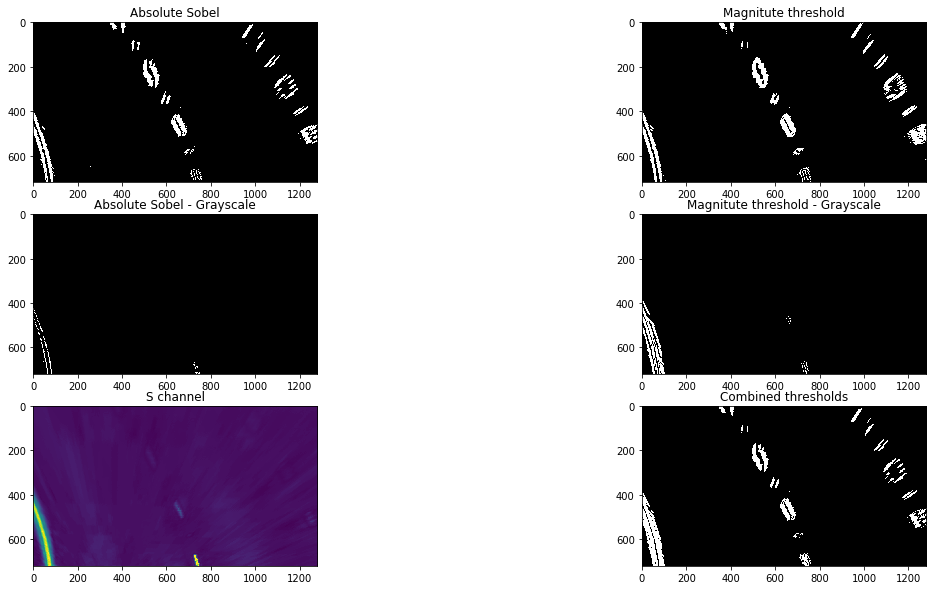

In [36]:
## Some my tests
combined_binary = convert_and_threshold(warped_curve)

## Locate the Lane Lines using histogram

In [37]:
def hist(img):
    [height, width] = img.shape
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[height//2:height,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

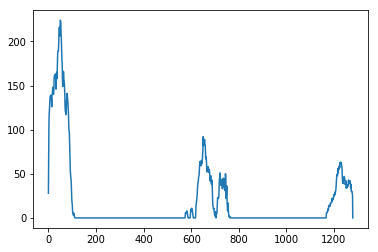

In [38]:
# Create histogram of image binary activations
histogram = hist(combined_binary)

# Visualize the resulting histogram
plt.plot(histogram)

#### Find histogram picks

In [39]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

50 650


In [40]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped*255, binary_warped*255, binary_warped*255))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

        # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

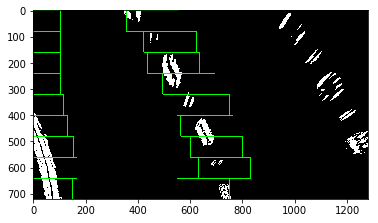

In [41]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(combined_binary)
plt.imshow(out_img)

In [42]:
def fit_polynomial(binary_warped):
   # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fit, right_fit, out_img

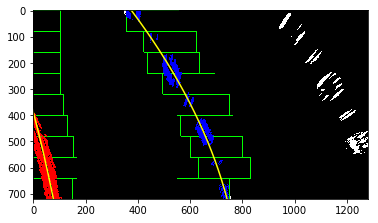

In [43]:
ploty, left_fit, right_fit, out_img = fit_polynomial(combined_binary)
plt.imshow(out_img)

In [45]:
left_fit

array([-9.46704729e-05,  3.36039174e-01, -1.15831631e+02])

## Search from prior

In [273]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# HYPERPARAMETER
# Choose the width of the margin around the previous polynomial to search
def search_around_poly(binary_warped, margin = 100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty

def visualization(binary_warped, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty, 
                  margin = 100):    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

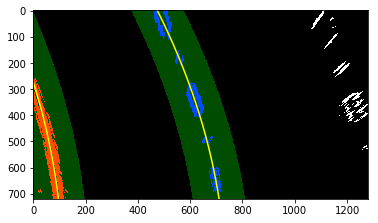

In [274]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty = search_around_poly(combined_binary)
result = visualization(combined_binary, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty)

# View your output
plt.imshow(result)

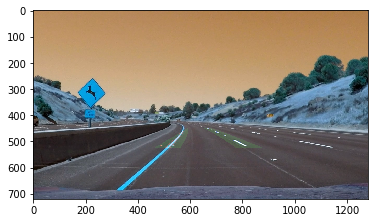

In [277]:
img_size = (result.shape[1], result.shape[0])
M_inv = np.linalg.inv(M)
warped_inv = cv2.warpPerspective(result, M_inv, img_size, flags=cv2.INTER_LINEAR)
# Combine the result with the original image
result = cv2.addWeighted(img_ref_curve, 1, warped_inv, 0.3, 0)
plt.imshow(result)

## Calculate curvation radius

In [237]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [238]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)

2323.548288561163 2163.240271492227


## Real world

In [239]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

2908.049487461011 m 2866.9877753962414 m
